In [78]:
import os, importlib, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import join, isfile
sys.path.append('../../code/src')
importlib.reload(sys.modules['box_model_source_apportionment'])
from box_model_source_apportionment import treat_box_model_output, get_initial_conc, get_daily_source_conc

In [ ]:
folderpath = '../../data/intermediate/box_model_output_bgX/'
filelist = [f for f in listdir(folderpath) if 
            isfile(join(folderpath, f))]
filelist = [s for s in filelist if 'results' in s ]

In [137]:
# blank df to store source contribution for all days
df_source_conc = pd.DataFrame()

# get saprc parameter acounted as PMF input
df_pmf = pd.read_csv('../../data/raw/PMF_species_saprc.csv')
list_saprc = df_pmf['SAPRC'].unique().tolist()
list_saprc.remove('NROG')

# calculate source concentration for all days
for i in range(len(filelist)):
    filepath = folderpath+filelist[i]
    date = filepath.split('/')[-1][8:18]
    df_initial = get_initial_conc(filepath)
    df_source_conc_daily = get_daily_source_conc(date, df_initial, list_saprc)
    df_source_conc = df_source_conc.append(df_source_conc_daily)

df_source_conc['Date'] = pd.to_datetime(df_source_conc['Date'])
df_source_conc['Conc'] = df_source_conc['Conc']*1.0e3  # convert from ppm to ppb
df_source_conc = df_source_conc.pivot_table(index='Date', columns='Factor', values='Conc').\
    reset_index()

In [138]:
# rename column names
df_source_conc = df_source_conc[['Date','X1','X3','X5','X4','X9','X8','X6','X7','X2']]
column_name = ['Date','Plant decomposition', 'Biogenic', 
               'Summer blend gasoline', 'Winter blend gasoline', 
               'Institutional refrigerator, air conditioning, cooking',
               'Education institution', 'Commercial and industrial solvents',
               'VCP(siloxane)', 'VCP(EtOH)']
df_source_conc.columns = column_name

## Combine with MDA8 O3 and O3 chemcial regime data

In [139]:
# O3 data (MDA8 O3)
df_O3_MDA8 = pd.read_csv('../../data/final/MDA8_O3_redlands.csv')
df_O3_MDA8['Date'] = pd.to_datetime(df_O3_MDA8['Date'])

# O3 data (chamber O3)
df_O3_chamber = pd.read_csv('../../data/final/O3_sensitivity_redlands.csv')
df_O3_chamber['Date'] = pd.to_datetime(df_O3_chamber['Date'])
df_O3_chamber.loc[df_O3_chamber['b1_b2_3hr']>0,'Regime'] = 'NOx-limited'
df_O3_chamber.loc[df_O3_chamber['b1_b2_3hr']<0,'Regime'] = 'VOC-limited'

# merge O3 data with source contribution
df_source_conc_merge = df_source_conc.merge(df_O3_MDA8[['Date','MDA8']], on='Date')
df_source_conc_merge = df_source_conc_merge.merge(df_O3_chamber[['Date','Regime']], on='Date')

## Plot bar by MDA8 O3

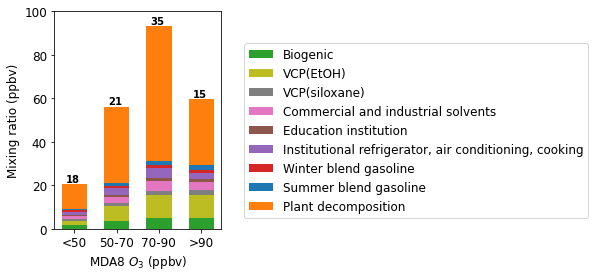

In [179]:
df_plot = df_source_conc_merge

# bin by MDA8 O3 50,70,90
df_plot['MDA8_bin'] = pd.cut(df_plot['MDA8'], bins=[0,50,70,90,120], 
                             labels=['<50','50-70','70-90','>90'])
df_plot_bin = df_plot.groupby('MDA8_bin').mean()
df_plot_bin = df_plot_bin[['Biogenic','VCP(EtOH)','VCP(siloxane)','Commercial and industrial solvents','Education institution','Institutional refrigerator, air conditioning, cooking','Winter blend gasoline','Summer blend gasoline','Plant decomposition']]
color_new = ['#2ca02c','#bcbd22','#7f7f7f','#e377c2','#8c564b','#9467bd','#d62728','#1f77b4','#ff7f0e']

# set text size
plt.rcParams.update({'font.size': 12})

fig, ax=plt.subplots(1, figsize=(3, 4))

x = df_plot_bin.index
bottom = np.zeros(len(x))

for i in np.arange(0,9,1):
    ax.bar(x, df_plot_bin.iloc[:,i], width=0.6,
           bottom=bottom, label=df_plot_bin.columns[i], color=color_new[i])
    bottom = bottom + df_plot_bin.iloc[:,i]

sample_size = df_plot.groupby('MDA8_bin').count().iloc[:,0]
for j in range(4):
    ax.text(j-0.2, bottom[j]+1, str(sample_size[j]), fontsize=10, fontweight='bold')

ax.set_ylim(0,100)
ax.legend(bbox_to_anchor=(1.1, 0.88))
ax.set_xlabel('MDA8 $O_3$ (ppbv)')
ax.set_ylabel('Mixing ratio (ppbv)')
fig.savefig('../../result/bar_source_conc_vs_MDA8O3.png', dpi=1200, bbox_inches='tight',facecolor='white')

## Plot bar by O3 chemical regime

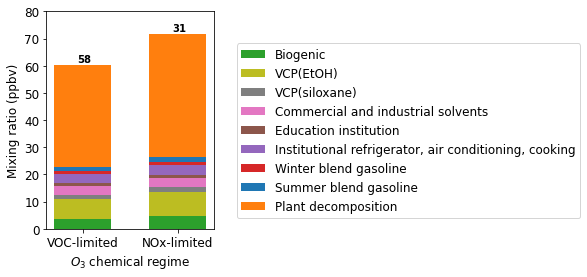

In [181]:
# bin by O3 sensitivity
df_plot_bin = df_plot.groupby('Regime').mean()
df_plot_bin = df_plot_bin[['Biogenic','VCP(EtOH)','VCP(siloxane)','Commercial and industrial solvents','Education institution','Institutional refrigerator, air conditioning, cooking','Winter blend gasoline','Summer blend gasoline','Plant decomposition']]
df_plot_bin = df_plot_bin.loc[['VOC-limited','NOx-limited']]

fig, ax=plt.subplots(1, figsize=(3, 4))

x = df_plot_bin.index
bottom = np.zeros(len(x))

for i in np.arange(0,9,1):
    ax.bar(x, df_plot_bin.iloc[:,i], width=0.6,
           bottom=bottom, label=df_plot_bin.columns[i], color=color_new[i])
    bottom = bottom + df_plot_bin.iloc[:,i]

sample_size = [58,31]
for j in [1,0]:
    ax.text(j-0.06, bottom[j]+1, str(sample_size[j]), fontsize=10, fontweight='bold')

ax.set_ylim(0,80)
ax.legend(bbox_to_anchor=(1.1, 0.88))
ax.set_xlabel('$O_3$ chemical regime')
ax.set_ylabel('Mixing ratio (ppbv)')
fig.savefig('../../result/bar_source_conc_vs_O3_sensitivity.png', dpi=1200, bbox_inches='tight',facecolor='white')